# The Louvain algorithm for network community detection

## Input data
The algorithm works on any weighted-nondirected network. This data could come in the form of a graphml, csv, spreadsheet etc. Whatever the format is, there is a specific format that we need to convert it to so that the following codes know what to do with it. The format we use here is a python dictionary in which the keys are the edges and the values are the weights of those edges. For example, 


In [74]:
graph={('a','b'):1,('a','c'):2,('b','c'):2,('c','d'):1,('d','e'):4,('e','g'):1,('f','g'):4,('f','d'):1}

describes a network of the type we want to work with. Lets take a look at what this network looks like;

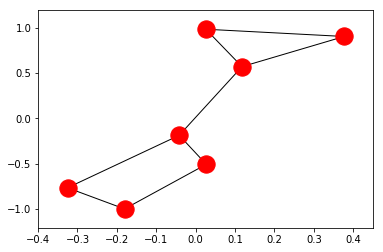

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

plt.figure()
G=nx.Graph()
for edge in graph:
    G.add_edge(edge[0],edge[1],weight=graph[edge])
    
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
plt.show()

## Calculating modularity
The Louvain algorithm maximizes modularity. If each node has a color then the modularity measures the relative likelihood that edges in the network will connect nodes of the same color. For example we can asign the following colors:

In [37]:
color= {'a': 'c0', 'b':'c1', 'c':'c2', 'd':'c1', 'e':'c1', 'f':'c0','g':'c2'} 

to get

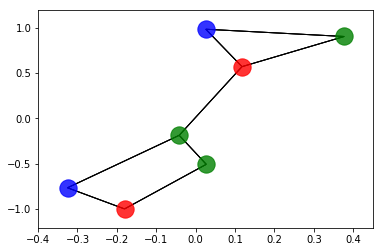

In [38]:
plt.figure()

color_list=['r','b','g','c','m','orange','yellow','k','pink']
n=0
for c in set(color.values()):
    nodes=[node for node in color if color[node]==c]
    nx.draw_networkx_nodes(G,pos,nodelist=nodes, node_color=color_list[n],alpha=0.8)
    n=n+1
    nx.draw_networkx_edges(G,pos)
plt.show()

To calculate the modularity of this coloring we use the formula
\begin{equation}
Q=\sum_{i,j} \left(w_{i,j}-\frac{s_{i}s_{j}}{S}\right)\delta(c_{i},c_{j})
\end{equation}
where $s_{i}=\sum_{j}w_{i,j}$ is the strength of the node $i$ and $S$ is the total strength of the graph $\sum_{i}s_{i}$, $c_{i}$ is the color of $i$ and $\delta$ is the Kroneckar $\delta$. To calculate this we will need a few things, starting with a list of all the nodes:

In [39]:
nodes=sorted(list(set([edge[0] for edge in graph]+[edge[1] for edge in graph])))
N=len(nodes)
print('nodes:',nodes)

nodes: ['a', 'b', 'c', 'd', 'e', 'f', 'g']


Notice that the formula calls for us to loop over every pair of nodes, regardless of whether there is an edge in the network or not. That means that we need to consider all the non-existent edges as having 0 weight

In [40]:
Weight={}
for i in nodes:
    for j in nodes:
        edge=tuple(sorted([i,j]))
        if (i,j) in graph:
            Weight[edge]=graph[(i,j)]
        elif (j,i) in graph:
            Weight[edge]=graph[(j,i)]
        else:
            Weight[edge]=0
print(Weight)

{('a', 'a'): 0, ('a', 'b'): 1, ('a', 'c'): 2, ('a', 'd'): 0, ('a', 'e'): 0, ('a', 'f'): 0, ('a', 'g'): 0, ('b', 'b'): 0, ('b', 'c'): 2, ('b', 'd'): 0, ('b', 'e'): 0, ('b', 'f'): 0, ('b', 'g'): 0, ('c', 'c'): 0, ('c', 'd'): 1, ('c', 'e'): 0, ('c', 'f'): 0, ('c', 'g'): 0, ('d', 'd'): 0, ('d', 'e'): 4, ('d', 'f'): 1, ('d', 'g'): 0, ('e', 'e'): 0, ('e', 'f'): 0, ('e', 'g'): 1, ('f', 'f'): 0, ('f', 'g'): 4, ('g', 'g'): 0}


Notice that when we read the edge from the network we sort it. The Louvain package contains a function $\verb|get_weights|$ that takes a graph as input, runs this last bit of code, and returns the dictionary of weights. 

We want to know the strength of every node

In [41]:
strength={}
for i in nodes:
    strength[i]=sum([graph[edge] for edge in graph if edge[0]==i])+sum([graph[edge] for edge in graph if edge[1]==i])
print('strength:',strength)

strength: {'a': 3, 'b': 3, 'c': 5, 'd': 6, 'e': 5, 'f': 5, 'g': 5}


and the total strength

In [42]:
total_weight=sum([strength[i] for i in nodes])
print('total strength:',total_weight)

total strength: 32


Now we can put it all together to find the modularity

In [43]:
Q=0
for edge in Weight:
    i=edge[0]
    j=edge[1]
    if color[i]==color[j]:
        x=Weight[edge]-(strength[i]*strength[j]/total_weight)
        if i==j: 
            Q=Q+x/total_weight
        else:
            Q=Q+2*x/total_weight
            
print('Modularity of this coloring =',Q)

Modularity of this coloring = -0.1015625


This code is included in the Louvain module and can be accessed as follows:

In [44]:
import Louvain
print('Q =',Louvain.modularity(Weight,color))

Q = -0.1015625


## Finding an optimal coloring

This is where the Louvain algorithm begins. Actually, to make things easier later on we first want to create an adjacency list for every node. We start with an empty dictionary and add each node as a neighbor of itself

In [45]:
neighbors={}
for i in nodes:
    neighbors[i]=list(set([edge[0] for edge in graph if edge[1]==i]+[edge[1] for edge in graph if edge[0]==i]))  

print(neighbors)

{'a': ['c', 'b'], 'b': ['c', 'a'], 'c': ['a', 'd', 'b'], 'd': ['c', 'e', 'f'], 'e': ['d', 'g'], 'f': ['d', 'g'], 'g': ['f', 'e']}


The procedure starts by asigning a unique color to every node. We are going to keep track of the node colors in two different ways,

In [58]:
# color tells us the color of each node
color={}
for n in range(N):
    i=nodes[n]
    # this will be the label for the color
    c='c'+str(n)
    color[i]=c 

The first part of the procedure is to compute the change in modularity that occurs when the color of a node changes. For a node, $i$ that changes color from $c_{1}$ to $c_{2}$ the magnitude of this change is 
\begin{equation}
\Delta Q=\frac{2}{S}\left(w_{i,c_{2}}-\frac{s_{i}(s_{i}+w_{c_{2}})}{S}-w_{i,c_{1}}+\frac{s_{i}w_{c_{1}}}{S}\right)   
\end{equation}

To compute this we need to know $w_{i,c_{k}}$, weight of edges of each node that link to any particular color
for all nodes and colors.

In [59]:
weight_in_color={}  
for i in nodes:
    for j in nodes:
        if j in neighbors[i]:
            weight_in_color[(j,color[i])]=Weight[tuple(sorted((i,j)))]
        else:
            weight_in_color[(j,color[i])]=0   

and we need to know $w_{c_{k}}$ the total weight of edges of each color

In [60]:
total_weight_of_color={}
for c in set(color.values()):
    total_weight_of_color[c]=sum([strength[i] for i in nodes if color[i]==c])

When each node is considered, the source is the color that it currently is and the target is the color that it may change to. T1 - T4 are the four terms in the equation for $\Delta Q$.

In [61]:
i='a'
source='c0'
target='c2'

T1=weight_in_color[(i,target)]+Weight[(i,i)]

T2=strength[i]*(strength[i]+total_weight_of_color[target])/total_weight
 
T3=weight_in_color[(i,source)]    

T4=strength[i]*total_weight_of_color[source]/total_weight

# compute the total change if ID moved from source community to target community
delta_Q=(T1-T2-T3+T4)*(2/total_weight)  

Just to prove that the formula is correct we can calculate the modularity befor and after making the change

In [62]:
Q_before=Louvain.modularity(Weight,color)
# make the change
color[i]=target
Q_after=Louvain.modularity(Weight,color)
print(Q_after-Q_before)
print(delta_Q)

# now reset it to how it was before so we don't mess things up!
color[i]=source

0.095703125
0.095703125


Now we have finally reached the fun part! The following is a loop that sequentially chooses nodes. It calculates, for every color, the change in Q that would occur if the node changed to that color, if the biggest change it finds is positive (and not tiny) then it makes that change.

In [63]:
# if no improvements occur in N iterations then this number reaches N and the loop ends
unsuccessful_iterations=0
# n is the index of the node we want to check
n=0
# the loop terminates when we iterate through every node and find that none of them yield an improvement
while unsuccessful_iterations<N:
    i=nodes[n]
    n=(n+1) % N
    # source is the community ID is currently in
    source=color[i]
    # compute the weight of edges between ID and nodes in source community (including itself)
    T3=weight_in_color[(i,source)]    
    # compute the expectation 
    T4=strength[i]*total_weight_of_color[source]/total_weight

    best_delta=0
    # instead of choosing all possible target colors, rule out the ones ID has no connection to
    for target in [x for x in set(color.values()) if x!=source]:           
        # compute the weight of edges between ID and nodes in target community (including itself)           
        T1 =weight_in_color[(i,target)]+Weight[(i,i)]
        # compute the expectation
        T2 =strength[i]*(strength[i]+total_weight_of_color[target])/total_weight
        # compute the total change if ID moved from source community to target community
        delta_Q=(T1-T2-T3+T4)*(1/total_weight)    

        # keep track of the largest
        if delta_Q>best_delta:    
            best_delta=delta_Q
            best_target=target

    if best_delta>0.00000001:

        color[i]=best_target

        # update the total_similarity of source
        total_weight_of_color[source]=total_weight_of_color[source]-strength[i]
        # update the total_similarity of target        
        total_weight_of_color[best_target]=total_weight_of_color[best_target]+strength[i]
        # update similarity to the source/target community of every node
        for j in neighbors[i]:
            weight_in_color[(j,source)]=weight_in_color[(j,source)]-Weight[tuple(sorted((i,j)))]
            weight_in_color[(j,best_target)]=weight_in_color[(j,best_target)]+Weight[tuple(sorted((i,j)))]

        # best delta is large so the iteration was successful. Reset the counter
        unsuccessful_iterations=0
    else:
        # if no improvements occur in N iterations then this number reaches N and the loop ends
        unsuccessful_iterations=unsuccessful_iterations+1
        
print(color)

{'a': 'c2', 'b': 'c2', 'c': 'c2', 'd': 'c4', 'e': 'c4', 'f': 'c6', 'g': 'c6'}


Lets plot the result to see if it worked!

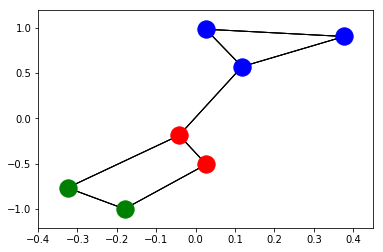

In [64]:
plt.figure()
n=0
for c in set(color.values()):
    node_group=[node for node in color if color[node]==c]
    nx.draw_networkx_nodes(G,pos,nodelist=node_group, node_color=color_list[n])
    n=n+1
    nx.draw_networkx_edges(G,pos)
plt.show()

Recomputing the modularity we have 

In [65]:
print('Q =',Louvain.modularity(Weight,color))

Q = 0.478515625


So that seems to have worked, however, there may still be room for improvement. The next stage of the algorithm looks to see if an improvement can be made by merging any pair of communities. 

## Merging communities
We make a new network with each color as a community 

In [66]:
# start by creating a Weight dictionary where all the pairs have weight 0
new_weight={}

for c_i in set(color.values()):
    for c_j in set(color.values()):
        new_edge=tuple(sorted((c_i,c_j)))
        if new_edge not in new_weight:
            new_weight[new_edge]=0
# for each of the old edges, add its weight to the weight of the appropriate new edge
for edge in Weight:
    # new-edge is the edge between two colors 
    new_edge=tuple(sorted((color[edge[0]],color[edge[1]])))
    # once we know which new edge to add to, we can add it
    new_weight[new_edge]=new_weight[new_edge]+Weight[edge]

print(color)
print(new_weight)

{'a': 'c2', 'b': 'c2', 'c': 'c2', 'd': 'c4', 'e': 'c4', 'f': 'c6', 'g': 'c6'}
{('c4', 'c4'): 4, ('c2', 'c4'): 1, ('c4', 'c6'): 2, ('c2', 'c2'): 5, ('c2', 'c6'): 0, ('c6', 'c6'): 4}


Everything we have done up to here is combined into one function in the Louvain module. The function $\verb|modulize|$ takes the dictionary Weight as input and gives a new graph as output. There next stage of the algorithm simply involves putting the the new network through the $\verb|modulize|$ process repeatedly until no changes occur.

In [67]:
new_weight,color=Louvain.modulize(Weight)

print(color)
print(new_weight)

{'a': 'c2', 'b': 'c2', 'c': 'c2', 'd': 'c4', 'e': 'c4', 'f': 'c6', 'g': 'c6'}
{('c4', 'c4'): 4, ('c2', 'c4'): 1, ('c4', 'c6'): 2, ('c2', 'c2'): 5, ('c2', 'c6'): 0, ('c6', 'c6'): 4}


nothing has changed so we have reached a local optimum. Notice now that the color groups are the names of colors (not nodes) so we need a way to recover the actual nodes. That means that each time we iterate we need to keep track of which nodes belong where. The following code does this

In [75]:
end_loop=False
number_of_modules=len(nodes)
final_color={}
for i in nodes:
    final_color[i]=i
#stopping criteria: no change has occured
while end_loop==False:     
    #partition produces 0) the partition 1) a dictionary of similarities between groups partition     
    graph,color=Louvain.modulize(graph)
    for i in nodes:
        final_color[i]=color[final_color[i]]  

    # if number of modules is the same then end the loop
    if number_of_modules==len(set(color.values())):
        end_loop=True
    else:
        number_of_modules=len(set(color.values()))  
print(final_color)

{'a': 'c0', 'b': 'c0', 'c': 'c0', 'd': 'c1', 'e': 'c1', 'f': 'c2', 'g': 'c2'}


In the Louvain package, the function $\verb|get_partition|$ does performs this action. Next we show the results on some real networks!

## Real networks

First we need to read the files and put them in the desired format

In [96]:
import pandas as pd
# choose a network from shark_0, parakeet_2_2, stumptailed_macaque, Howler_monkeys, Macaques_Massen
network='Howler_monkeys'
df=pd.read_csv('Data/'+network+'_edgelist.csv')

graph={}
for i,row in df.iterrows():
    graph[(row['ID1'],row['ID2'])]=row['Weight']
    
color=Louvain.get_colors(graph)

Often it is better to have the result in th for of a partition

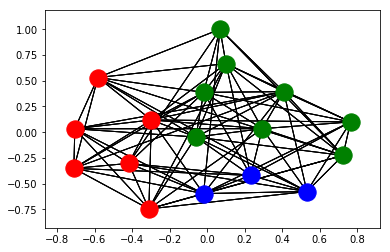

In [97]:
plt.figure()
G=nx.Graph()
for edge in graph:
    G.add_edge(edge[0],edge[1],weight=graph[edge])
pos=nx.spring_layout(G)

n=0
for c in set(color.values()):
    node_group=[node for node in color if color[node]==c]
    nx.draw_networkx_nodes(G,pos,nodelist=node_group, node_color=color_list[n])
    n=n+1
    nx.draw_networkx_edges(G,pos)
plt.show()

In [99]:
Q=Louvain.modularity(graph,color)
print(Q)

-0.0801098395264
